## Packages

In [19]:
import cv2
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

## Load and Preprocess Data

In [20]:
class HOIDataset(Dataset):
    def __init__(self, transform, data_list, label_list):
        self.imgs_path = "vcoco_dataset/"
        self.transform = transform
        self.data = []
        for i in range(len(data_list)):
            img_path = data_list[i]
            class_name = label_list[i]
            agent_path = img_path + '/agent.jpg'
            object_path = img_path + '/object.jpg'
            union_path = img_path + '/union.jpg'
            self.data.append([agent_path, object_path, union_path, class_name])

        self.class_map = {
            'carry': 0,
            'catch': 1,
            'hold': 2,
            'jump': 3,
            'lay': 4,
            'look': 5,
            'ride': 6,
            'sit': 7,
            'skateboard': 8,
            'ski': 9,
            'snowboard': 10,
            'surf': 11,
            'talk_on_phone': 12,
            'throw': 13,
            'work_on_computer': 14
        }
    
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self, idx):
        agent_path, object_path, union_path, class_name = self.data[idx]
        agent_img = Image.open(agent_path)
        object_img = Image.open(object_path)
        union_img = Image.open(union_path)
        
        if self.transform:
            agent_img = self.transform(agent_img)
            object_img = self.transform(object_img)
            union_img = self.transform(union_img)

        trans = transforms.Compose([ 
            transforms.ToTensor() 
        ]) 
        agent = trans(agent_img)
        object = trans(object_img)
        union = trans(union_img)
        class_id = self.class_map[class_name]
        one_hot_class = torch.Tensor([0] * 15)
        one_hot_class[class_id] += 1
        
        return agent, object, union, one_hot_class

In [21]:
class PadToSquare:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - h) // 2
        wp = (max_wh - w) // 2
        padding = (wp, hp, wp, hp)
        return transforms.functional.pad(image, padding, fill=0, padding_mode='constant')
    
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        return transforms.functional.resize(image, self.output_size)

class PadAndRescale:
    def __init__(self, output_size):
        self.pad = PadToSquare()
        self.rescale = Rescale(output_size)

    def __call__(self, image):
        image = self.pad(image)
        image = self.rescale(image)
        return image


In [22]:
data_list = []
label_list = []
X_catch_throw = []
X_sit_ride = []
y_catch_throw = []
y_sit_ride = []
imgs_path = "training_data/"
file_list = glob.glob(imgs_path + "*")
# skateboard_snowboard_set = set()
# ride_set = set()

'''
for class_path in file_list:
    class_name = class_path.split("\\")[-1]
    if class_name=='skateboard' or class_name=='snowboard':
        for img_path in glob.glob(class_path + "/*"):
            skateboard_snowboard_set.add(img_path.split("\\")[-1])
    elif class_name=='ride':
        for img_path in glob.glob(class_path + "/*"):
            ride_set.add(img_path.split("\\")[-1])
'''

skipped_action = ['drink',  'kick', 'point', 'read']
for class_path in file_list:
    class_name = class_path.split("\\")[-1]
    '''
    if len(glob.glob(class_path + "/*")) < 300:
        continue
    '''
    if class_name in skipped_action:
        continue
    num_img = 0
    for img_path in glob.glob(class_path + "/*"):
        '''
        if class_name=='sit' and img_path.split("\\")[-1] in ride_set:
            print(img_path)
            continue
        
        if class_name in ['catch', 'throw']:
            print(img_path)
            X_catch_throw.append(img_path)
            y_catch_throw.append(class_name)
        elif class_name in ['sit', 'ride']:
            X_sit_ride.append(img_path)
            y_sit_ride.append(class_name)
        '''
        
        data_list.append(img_path)
        label_list.append(class_name)
        num_img += 1
        if num_img > 417:
            break
    print("class_name: ", class_name)
    print("num_img: ", num_img)

# Split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data_list, label_list, test_size=0.1, random_state=42)
# train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=(1/9), random_state=42)

# Create HOIDatasets
transform = PadAndRescale(output_size=(128, 128))
train_dataset = HOIDataset(transform = transform, data_list = train_data, label_list = train_labels)
test_dataset = HOIDataset(transform = transform, data_list = test_data, label_list = test_labels)
# val_dataset = HOIDataset(transform = transform, data_list = val_data, label_list = val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class_name:  carry
num_img:  418
class_name:  catch
num_img:  418
class_name:  hold
num_img:  418
class_name:  jump
num_img:  418
class_name:  lay
num_img:  418
class_name:  look
num_img:  418
class_name:  ride
num_img:  418
class_name:  sit
num_img:  418
class_name:  skateboard
num_img:  418
class_name:  ski
num_img:  418
class_name:  snowboard
num_img:  418
class_name:  surf
num_img:  418
class_name:  talk_on_phone
num_img:  418
class_name:  throw
num_img:  418
class_name:  work_on_computer
num_img:  418


## Model

convlayers = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
    nn.BatchNorm2d(96),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),

    nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),

    nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(384),
    nn.ReLU(),
    
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2),
    nn.BatchNorm2d(384),
    nn.ReLU(),
    
    nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2),
    nn.BatchNorm2d(256),
    nn.ReLU()
)

### Human Stream

import copy
hs_model = copy.deepcopy(convlayers)
hs_model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
hs_model.append(nn.Flatten())
hs_model.append(nn.Linear(256 * 4 * 4, 4096))
hs_model.append(nn.ReLU())
hs_model.append(nn.Dropout(p=0.5))
hs_model.append(nn.Linear(4096, 600))
hs_model.append(nn.ReLU())
hs_model.append(nn.Dropout(p=0.5))
hs_model.append(nn.Linear(600, 15))
hs_model.append(nn.Sigmoid())

### Object Stream

os_model = copy.deepcopy(convlayers)
os_model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
os_model.append(nn.Flatten())
os_model.append(nn.Linear(256 * 4 * 4, 4096))
os_model.append(nn.ReLU())
os_model.append(nn.Dropout(p=0.5))
os_model.append(nn.Linear(4096, 600))
os_model.append(nn.ReLU())
os_model.append(nn.Dropout(p=0.5))
os_model.append(nn.Linear(600, 15))
os_model.append(nn.Sigmoid())

### Pairwise Stream

'''
ps_model = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=5),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(96, 64, kernel_size=5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(64, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(5408, 600),
    nn.ReLU(),
    nn.Linear(600, 15),
    nn.Sigmoid()
)
'''
ps_model = copy.deepcopy(convlayers)
ps_model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
ps_model.append(nn.Flatten())
ps_model.append(nn.Linear(256 * 4 * 4, 4096))
ps_model.append(nn.ReLU())
ps_model.append(nn.Dropout(p=0.5))
ps_model.append(nn.Linear(4096, 600))
ps_model.append(nn.ReLU())
ps_model.append(nn.Dropout(p=0.5))
ps_model.append(nn.Linear(600, 13))
ps_model.append(nn.Sigmoid())

## Training

### Hyperparameters

num_epochs = 20

criterion = nn.CrossEntropyLoss()
h_optimizer = optim.Adam(hs_model.parameters(), lr=0.0001)
o_optimizer = optim.Adam(os_model.parameters(), lr=0.0001)
p_optimizer = optim.Adam(ps_model.parameters(), lr=0.0001)

for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}')):
        
        h_input, o_input, p_input, y = data
        
        h_optimizer.zero_grad()
        o_optimizer.zero_grad()
        p_optimizer.zero_grad()

        h_yhat = hs_model(h_input)
        o_yhat = os_model(o_input)
        p_yhat = ps_model(p_input)

        yhat = (h_yhat + o_yhat + p_yhat) / 3.0
        
        loss = criterion(yhat, y)
        loss.backward()
        h_optimizer.step()
        o_optimizer.step()
        p_optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
    val_loss = 0.0
    val_steps = 0
    hs_model.eval()
    os_model.eval()
    ps_model.eval()
    
    with torch.no_grad():
        correct = 0
        wrong = 0
        action_real = [0] * 13
        action_predict = [0] * 13
        for val_data in tqdm(test_loader, desc=f'Validation Epoch {epoch + 1}'):
            h_input, o_input, p_input, y = val_data
            
            h_yhat = hs_model(h_input)
            o_yhat = os_model(o_input)
            p_yhat = ps_model(p_input)

            y_hat = (h_yhat + o_yhat + p_yhat) / 3.0

            predicted = torch.argmax(y_hat.data, 1)
            action_predict[predicted] += 1

            true_labels = torch.argmax(y, 1)
            action_real[true_labels] += 1

            for i in range(len(true_labels)):
                if predicted==true_labels:
                    correct += 1
                else:
                    wrong += 1
            loss = criterion(y_hat, y)
            val_loss += loss.item()
            val_steps += 1

    avg_val_loss = val_loss / val_steps
    accuracy = correct / (correct + wrong)
    print(f'Epoch {epoch + 1} | validation loss: {avg_val_loss:.3f} | accuracy: {accuracy}')
    print(action_real)
    print(action_predict)

# Load the saved weights
PATH = './hs_model_weights.pth'
hs_model.load_state_dict(torch.load(PATH))
hs_model.eval()

PATH = './os_model_weights.pth'
os_model.load_state_dict(torch.load(PATH))
os_model.eval()

PATH = './ps_model_weights.pth'
ps_model.load_state_dict(torch.load(PATH))
ps_model.eval()

## Evaluation

correct = 0
wrong = 0
count = 0

for i, data in enumerate(test_loader):
    
    h_input, o_input, p_input, y = data
    
    h_yhat = hs_model(h_input)
    o_yhat = os_model(o_input)
    p_yhat = ps_model(p_input)
    
    yhat = (h_yhat + o_yhat + p_yhat) / 3.0
    
    # Get the predicted class for each input in the batch
    predicted = torch.argmax(yhat.data, 1)

    # Get the correct class indices
    true_labels = torch.argmax(y, 1)

    if predicted==true_labels:
        correct += 1
    else:
        wrong += 1

accuracy = correct / (correct + wrong)
print(f"correct: {correct}, wrong: {wrong}, accuracy: {accuracy}")
        

In [23]:
from torchvision import models
net = models.alexnet(pretrained=True)

net.classifier[6] = nn.Linear(in_features=4096, out_features=15, bias=True)

net.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
import copy
hs_model = copy.deepcopy(net)
os_model = copy.deepcopy(net)
# ps_model = copy.deepcopy(net)
ps_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(64, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(5408, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 15),
    nn.Sigmoid()
)

In [25]:
num_epochs = 5

In [26]:
criterion = nn.CrossEntropyLoss()

h_optimizer = optim.Adam(hs_model.parameters(), lr=0.0001)
o_optimizer = optim.Adam(os_model.parameters(), lr=0.0001)
p_optimizer = optim.Adam(ps_model.parameters(), lr=0.0001)

In [27]:
for epoch in range(num_epochs): 

    running_loss = 0.0
    correct = 0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}')):
        
        h_input, o_input, p_input, y = data
        
        h_optimizer.zero_grad()
        o_optimizer.zero_grad()
        p_optimizer.zero_grad()

        h_yhat = hs_model(h_input)
        o_yhat = os_model(o_input)
        p_yhat = ps_model(p_input)

        yhat = (h_yhat + o_yhat + p_yhat) / 3.0
        
        loss = criterion(yhat, y)
        loss.backward()
        h_optimizer.step()
        o_optimizer.step()
        p_optimizer.step()

        correct += sum(torch.argmax(yhat, 1)==torch.argmax(y, 1)).item()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            print(f'Training accuracy: {correct / 3200}')
            correct = 0
            running_loss = 0.0
            
    val_loss = 0.0
    val_steps = 0
    hs_model.eval()
    os_model.eval()
    ps_model.eval()
    
    with torch.no_grad():
        correct = 0
        wrong = 0
        action_real = [0] * 15
        action_predict = [0] * 15
        for val_data in tqdm(test_loader, desc=f'Validation Epoch {epoch + 1}'):
            h_input, o_input, p_input, y = val_data
            
            h_yhat = hs_model(h_input)
            o_yhat = os_model(o_input)
            p_yhat = ps_model(p_input)

            y_hat = (h_yhat + o_yhat + p_yhat) / 3.0

            predicted = torch.argmax(y_hat.data, 1)
            action_predict[predicted] += 1

            true_labels = torch.argmax(y, 1)
            action_real[true_labels] += 1

            for i in range(len(true_labels)):
                if predicted==true_labels:
                    correct += 1
                else:
                    wrong += 1
            loss = criterion(y_hat, y)
            val_loss += loss.item()
            val_steps += 1

    avg_val_loss = val_loss / val_steps
    accuracy = correct / (correct + wrong)
    print(f'Epoch {epoch + 1} | validation loss: {avg_val_loss:.3f} | accuracy: {accuracy}')
    print(action_real)
    print(action_predict)

Epoch 1:  56%|████████████████████████████████████████                               | 100/177 [03:51<02:49,  2.20s/it]

[1,   100] loss: 1.829
Training accuracy: 0.3934375


Validation Epoch 1: 100%|████████████████████████████████████████████████████████████| 627/627 [00:31<00:00, 19.62it/s]


Epoch 1 | validation loss: 1.377 | accuracy: 0.5486443381180224
[54, 44, 38, 41, 39, 32, 41, 49, 33, 40, 42, 46, 38, 40, 50]
[66, 74, 3, 19, 36, 2, 50, 48, 57, 56, 32, 53, 55, 38, 38]


Epoch 2:  56%|████████████████████████████████████████                               | 100/177 [03:21<02:40,  2.08s/it]

[2,   100] loss: 1.127
Training accuracy: 0.5965625


Validation Epoch 2: 100%|████████████████████████████████████████████████████████████| 627/627 [00:29<00:00, 20.95it/s]


Epoch 2 | validation loss: 1.341 | accuracy: 0.5103668261562998
[54, 44, 38, 41, 39, 32, 41, 49, 33, 40, 42, 46, 38, 40, 50]
[31, 101, 16, 51, 34, 40, 56, 61, 34, 42, 10, 41, 52, 10, 48]


Epoch 3:  56%|████████████████████████████████████████                               | 100/177 [03:26<02:39,  2.07s/it]

[3,   100] loss: 0.873
Training accuracy: 0.68625


Validation Epoch 3: 100%|████████████████████████████████████████████████████████████| 627/627 [00:30<00:00, 20.54it/s]


Epoch 3 | validation loss: 1.335 | accuracy: 0.5151515151515151
[54, 44, 38, 41, 39, 32, 41, 49, 33, 40, 42, 46, 38, 40, 50]
[38, 60, 71, 36, 38, 18, 34, 23, 42, 61, 23, 52, 48, 35, 48]


Epoch 4:  56%|████████████████████████████████████████                               | 100/177 [03:21<02:34,  2.01s/it]

[4,   100] loss: 0.658
Training accuracy: 0.751875


Validation Epoch 4: 100%|████████████████████████████████████████████████████████████| 627/627 [00:30<00:00, 20.82it/s]


Epoch 4 | validation loss: 1.313 | accuracy: 0.518341307814992
[54, 44, 38, 41, 39, 32, 41, 49, 33, 40, 42, 46, 38, 40, 50]
[63, 19, 10, 37, 30, 25, 49, 44, 42, 39, 43, 46, 53, 80, 47]


Epoch 5:  56%|████████████████████████████████████████                               | 100/177 [03:23<02:30,  1.95s/it]

[5,   100] loss: 0.586
Training accuracy: 0.775625


Validation Epoch 5: 100%|████████████████████████████████████████████████████████████| 627/627 [00:31<00:00, 20.18it/s]

Epoch 5 | validation loss: 1.434 | accuracy: 0.5247208931419458
[54, 44, 38, 41, 39, 32, 41, 49, 33, 40, 42, 46, 38, 40, 50]
[62, 55, 23, 21, 31, 40, 65, 35, 56, 42, 57, 30, 43, 20, 47]


In [28]:
# save weights
PATH = './hs_model_weights_original_dataset.pth'
torch.save(hs_model.state_dict(), PATH)

PATH = './os_model_weights_original_dataset.pth'
torch.save(os_model.state_dict(), PATH)

PATH = './ps_model_weights_original_dataset.pth'
torch.save(ps_model.state_dict(), PATH)

In [29]:
# Load the saved weights
PATH = './hs_model_weights_original_dataset.pth'
hs_model.load_state_dict(torch.load(PATH))
hs_model.eval()

PATH = './os_model_weights_original_dataset.pth'
os_model.load_state_dict(torch.load(PATH))
os_model.eval()

PATH = './ps_model_weights_original_dataset.pth'
ps_model.load_state_dict(torch.load(PATH))
ps_model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=5408, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=512, bias=True)
  (18): Re

In [30]:
correct = 0
wrong = 0
count = 0
action_real = [0 for i in range(15)]
action_predict = [0 for i in range(15)]
predictions = []
true_label = []
for i, data in enumerate(test_loader):
    
    h_input, o_input, p_input, y = data
    
    h_yhat = hs_model(h_input)
    o_yhat = os_model(o_input)
    p_yhat = ps_model(p_input)
    
    yhat = (h_yhat + o_yhat + p_yhat) / 3.0
    
    # Get the predicted class for each input in the batch
    predicted = torch.argmax(yhat.data, 1)
    action_predict[predicted] += 1
    predictions.append(predicted)
    
    # Get the correct class indices
    true_labels = torch.argmax(y, 1)
    action_real[true_labels] += 1
    true_label.append(true_labels)
    
    for i in range(len(true_labels)):
        if predicted==true_labels:
            correct += 1
        else:
            wrong += 1

accuracy = correct / (correct + wrong)
print(f"correct: {correct}, wrong: {wrong}, accuracy: {accuracy}")
# ans = [action_predict[i]/action_real[i] for i in range(15)]
# print(ans)

correct: 329, wrong: 298, accuracy: 0.5247208931419458


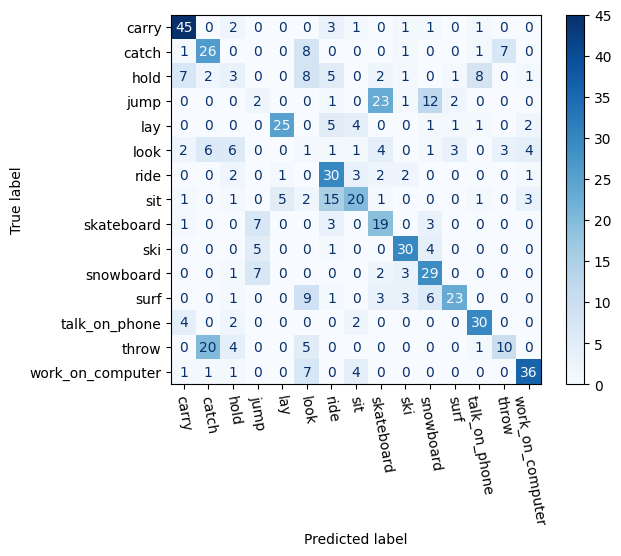

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

class_map = {
    'carry': 0,
    'catch': 1,
    'hold': 2,
    'jump': 3,
    'lay': 4,
    'look': 5,
    'ride': 6,
    'sit': 7,
    'skateboard': 8,
    'ski': 9,
    'snowboard': 10,
    'surf': 11,
    'talk_on_phone': 12,
    'throw': 13,
    'work_on_computer': 14
}

# Ensure action_real and action_predict are defined
action_real = np.array(action_real)  
action_predict = np.array(action_predict)
action_real = action_real.squeeze()
action_predict = action_predict.squeeze()

confusion_matrix = metrics.confusion_matrix(true_label, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_map.keys())

cm_display.plot(cmap = 'Blues', xticks_rotation=280)
cm_display.figure_.savefig("matrix.png")
plt.show()